# Attempt 1

## Description
* simple ML training model
* Dataset training data contained 20 labeled sample questions for each question type; testing dataset had 7 of each. 
* has non-probability and vaguely probability related questions in the dataset so it knows that not every question is classifiable with our classifications. 
* This model only classifies what kind of problem this is, then tells you what it thinks.

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

# Load the training dataset
train_dataset = pd.read_excel("LLM_question_dataset.xlsx", sheet_name="llm_training_dataset")

# Preprocess the training dataset
X_train = train_dataset["Problem Statement"]  # Input features
y_train = train_dataset["Problem Type"]       # Labels

# Train a simple text classification model
model = make_pipeline(CountVectorizer(), MultinomialNB())  # Create a pipeline
model.fit(X_train, y_train)  # Train the model

# Load the testing dataset
test_dataset = pd.read_excel("LLM_question_dataset.xlsx", sheet_name="llm_test_dataset")

In [ ]:
# Preprocess the testing dataset
X_test = test_dataset["Problem Statement"]  # Input features
y_test = test_dataset["Problem Type"]       # Labels

# Evaluate the model on the testing set
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# # Save the trained model to a file
# joblib.dump(model, "trained_model.pkl")
# print("Model trained and saved to 'trained_model.pkl'.")

Classification Report:
                              precision    recall  f1-score   support

        Bayesian Probability       1.00      1.00      1.00         7
           Bernoulli Process       0.50      0.71      0.59         7
        Binomial Probability       0.60      0.43      0.50         7
                Combinations       1.00      1.00      1.00         7
       Geometric Probability       1.00      1.00      1.00         7
                Permutations       1.00      1.00      1.00         7
Probability Density Function       1.00      1.00      1.00         7
             not probability       1.00      1.00      1.00         7
                     p-value       1.00      1.00      1.00         7
           vague probability       1.00      0.86      0.92         7

                    accuracy                           0.90        70
                   macro avg       0.91      0.90      0.90        70
                weighted avg       0.91      0.90      0.90      

In [5]:
# Testing
import joblib

# Load the trained model
def load_model(file_path):
    return joblib.load(file_path)

# Classify a problem statement
def classify_problem(model, problem_statement):
    # Predict the problem type
    prediction = model.predict([problem_statement])[0]
    return prediction

# Generate a response based on the classification
def generate_response(classification, uncertainty_flag):
    if uncertainty_flag == "True" or classification in ["vague probability", "not probability"]:
        return "I can't determine what kind of problem this is."
    else:
        return f"I think this is a {classification} type question. [Click here](url)"

# Main function
def main():
    # Load the trained model
    model = load_model("trained_model.pkl")

    # Interactive loop for user input
    while True:
        # Get user input
        problem_statement = input("Enter a problem statement (or type 'exit' to quit): ")
        if problem_statement.lower() == "exit":
            break

        # Classify the problem
        classification = classify_problem(model, problem_statement)

        # Check the uncertainty flag (assume False for user input)
        uncertainty_flag = "False"

        # Generate and print the response
        response = generate_response(classification, uncertainty_flag)
        print(response)

if __name__ == "__main__":
    main()

I think this is a p-value type question. [Click here](url)
I think this is a Bernoulli Process type question. [Click here](url)
I think this is a Combinations type question. [Click here](url)
I think this is a Probability Density Function type question. [Click here](url)
I can't determine what kind of problem this is.
I can't determine what kind of problem this is.
I think this is a Binomial Probability type question. [Click here](url)
I think this is a Binomial Probability type question. [Click here](url)
I think this is a Permutations type question. [Click here](url)
I think this is a Combinations type question. [Click here](url)
I think this is a Combinations type question. [Click here](url)
I think this is a Combinations type question. [Click here](url)
I think this is a Combinations type question. [Click here](url)
I think this is a Combinations type question. [Click here](url)
I think this is a Combinations type question. [Click here](url)


It sucks.

# Attempt 2

## Description
* I considered building an NLP LSTM deep learning model to look out for certain word clusters. 
* Replaces numbers with their string version (ex: 6 = "six") instead of removing them since I was certain they'd be important for classification. 
* example usage also replaces numbers in your input with strings.   

**Note:** 
* Model seems to have trouble with non-probability and vague probability questions. 
* I decided to add the uncertainty flag parameter into consideration. It actually made the model even *less* accurate and did nothing for those two classifications.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import string

# Function to replace numbers with words
from num2words import num2words

def replace_numbers(text):
    return re.sub(r'\d+', lambda x: num2words(int(x.group())), text)

# Load dataset
df_train = pd.read_excel("LLM_question_dataset.xlsx", sheet_name="llm_training_dataset")
df_test = pd.read_excel("LLM_question_dataset.xlsx", sheet_name="llm_test_dataset")

# Preprocess text
def clean_text(text):
    text = replace_numbers(text)
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    return text

df_train["Processed Statement"] = df_train["Problem Statement"].apply(clean_text)
df_test["Processed Statement"] = df_test["Problem Statement"].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df_train["Encoded Type"] = label_encoder.fit_transform(df_train["Problem Type"])

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train["Processed Statement"])

X_train = pad_sequences(tokenizer.texts_to_sequences(df_train["Processed Statement"]), maxlen=50)
y_train = df_train["Encoded Type"].values

X_test = pad_sequences(
    tokenizer.texts_to_sequences(df_test["Processed Statement"]), maxlen=50)

# Build LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=50),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

# Function for prediction
def classify_problem(statement):
    processed = clean_text(statement)
    sequence = pad_sequences(tokenizer.texts_to_sequences([processed]), maxlen=50)
    pred = model.predict(sequence)
    class_index = np.argmax(pred)
    class_name = label_encoder.inverse_transform([class_index])[0]
    
    if class_name in ["not probability", "vague probability"]:
        return "I can't determine what kind of problem this is."
    else:
        return f"I think this is a {class_name} problem. [Click here](url)"




Epoch 1/10


/home/r/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.1438 - loss: 2.2891 - val_accuracy: 0.0000e+00 - val_loss: 2.6391
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1305 - loss: 2.1453 - val_accuracy: 0.0000e+00 - val_loss: 3.2400
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3096 - loss: 1.9318 - val_accuracy: 0.0000e+00 - val_loss: 4.3953
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3827 - loss: 1.7980 - val_accuracy: 0.0244 - val_loss: 5.4240
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4868 - loss: 1.6539 - val_accuracy: 0.0244 - val_loss: 5.6694
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4881 - loss: 1.4684 - val_accuracy: 0.0244 - val_loss: 6.1950
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3941 - loss: 1.3226 - val_accuracy: 0.0244 - val_loss: 6.3124
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6532 - loss: 1.0807 - val_accuracy: 0.0244 - 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


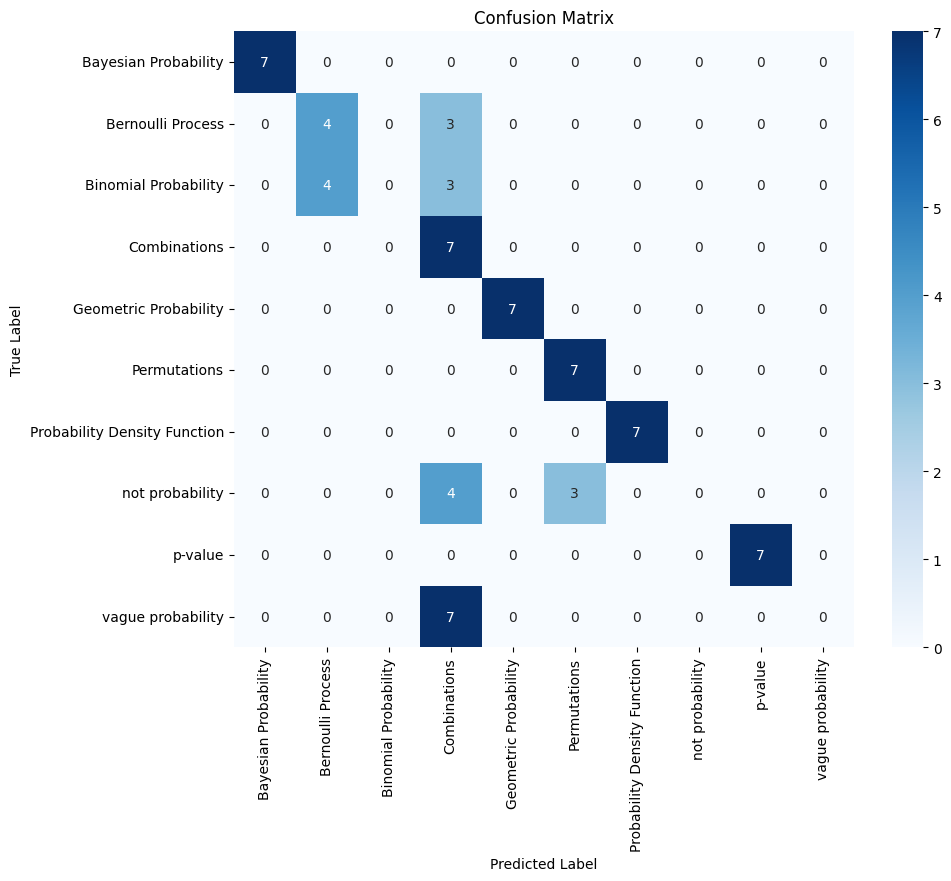

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
I think this is a Combinations problem. [Click here](url)
question was:" A basketball player has a seventy% free throw success rate. What is the probability of making exactly five out of eight free throws? "


In [ ]:
# Evaluate model (confusion matrix using test dataset, then testing model w/ a question)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the index of the class with the highest probability

# Get true labels
y_true = df_test["Problem Type"].apply(lambda x: label_encoder.transform([x])[0]).values

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Example usage
example_statement = "A basketball player has a 70% free throw success rate. What is the probability of making exactly 5 out of 8 free throws?"
example_statement = replace_numbers(example_statement)

print(classify_problem(example_statement))
print("question was:\"", example_statement, "\"")


# Attempt 3

## Description
* Updated Attempt 2 model by: 
    * grouping all binomial related probability categories together under "binomial" (classifications merged: "binomial", "geometric probability", and "bernoulli process") (**attempt 3a**)
    *  Grouping combinations and permutations together. (**attempt 3b**)

## Notes: 
* model functionality is now more narrow (or more streamlined, depending on if whether you're the glass half full or glass half empty type)
* however, its technically more accurate. It correctly identified all binomial and P&C questions. 
    * We could make it so a second model or another layer determines what kind of binomial question or what kind of P&C question it is.
* It still has issues with non-probability and vague probability questions.
    * Attempt 3a: 5/7 vague
    * 2/7 

### Attempt 3a: (combined binomial related classifications)

In [46]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import string

# Function to replace numbers with words
from num2words import num2words

def replace_numbers(text):
    return re.sub(r'\d+', lambda x: num2words(int(x.group())), text)

# Load dataset
df_train = pd.read_excel("LLM_question_dataset.xlsx", sheet_name="llm_training_dataset")
df_test = pd.read_excel("LLM_question_dataset.xlsx", sheet_name="llm_test_dataset")

# Preprocess text
def clean_text(text):
    text = replace_numbers(text)
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    return text

df_train["Processed Statement"] = df_train["Problem Statement"].apply(clean_text)
df_test["Processed Statement"] = df_test["Problem Statement"].apply(clean_text)

# Merge 'binomial', 'bernoulli', and 'geometric' into 'binomial probability'
df_train["Problem Type"] = df_train["Problem Type"].replace(
    {"Bernoulli Process": "Binomial Probability", 
     "Geometric Probability": "Binomial Probability", 
     "Binomial Probability": "Binomial Probability"})

df_test["Problem Type"] = df_test["Problem Type"].replace(
    {"Bernoulli Process": "Binomial Probability", 
     "Geometric Probability": "Binomial Probability", 
     "Binomial Probability": "Binomial Probability"})

# Encode labels
label_encoder = LabelEncoder()
df_train["Encoded Type"] = label_encoder.fit_transform(df_train["Problem Type"])

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train["Processed Statement"])

X_train = pad_sequences(tokenizer.texts_to_sequences(df_train["Processed Statement"]), maxlen=50)
y_train = df_train["Encoded Type"].values

X_test = pad_sequences(
    tokenizer.texts_to_sequences(df_test["Processed Statement"]), maxlen=50)

# Build LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=50),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

# Function for prediction
def classify_problem(statement):
    processed = clean_text(statement)
    sequence = pad_sequences(tokenizer.texts_to_sequences([processed]), maxlen=50)
    pred = model.predict(sequence)
    class_index = np.argmax(pred)
    class_name = label_encoder.inverse_transform([class_index])[0]
    
    # Merge 'binomial probability' categories into a single label for prediction
    if class_name == "Binomial Probability":
        return "I think this is a binomial probability (binomial, bernoulli, or geometric) problem."
    else:
        return f"I think this is a {class_name} problem. [Click here](url)"

# Example usage
example_statement = "What is the probability of rolling a 6 on a die?"
print(classify_problem(example_statement))


Epoch 1/10


/home/r/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2426 - loss: 2.0715 - val_accuracy: 0.0000e+00 - val_loss: 2.1441
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3604 - loss: 1.9651 - val_accuracy: 0.0000e+00 - val_loss: 2.4717
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3650 - loss: 1.7268 - val_accuracy: 0.4878 - val_loss: 2.3507
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3850 - loss: 1.4605 - val_accuracy: 0.0244 - val_loss: 2.4339
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4966 - loss: 1.2431 - val_accuracy: 0.0000e+00 - val_loss: 2.6064
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5786 - loss: 1.0473 - val_accuracy: 0.0000e+00 - val_loss: 2.8513
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7333 - loss: 0.8110 - val_accuracy: 0.0000e+00 - val_loss: 3.0054
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7453 - loss: 0.8120 - val_accuracy: 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


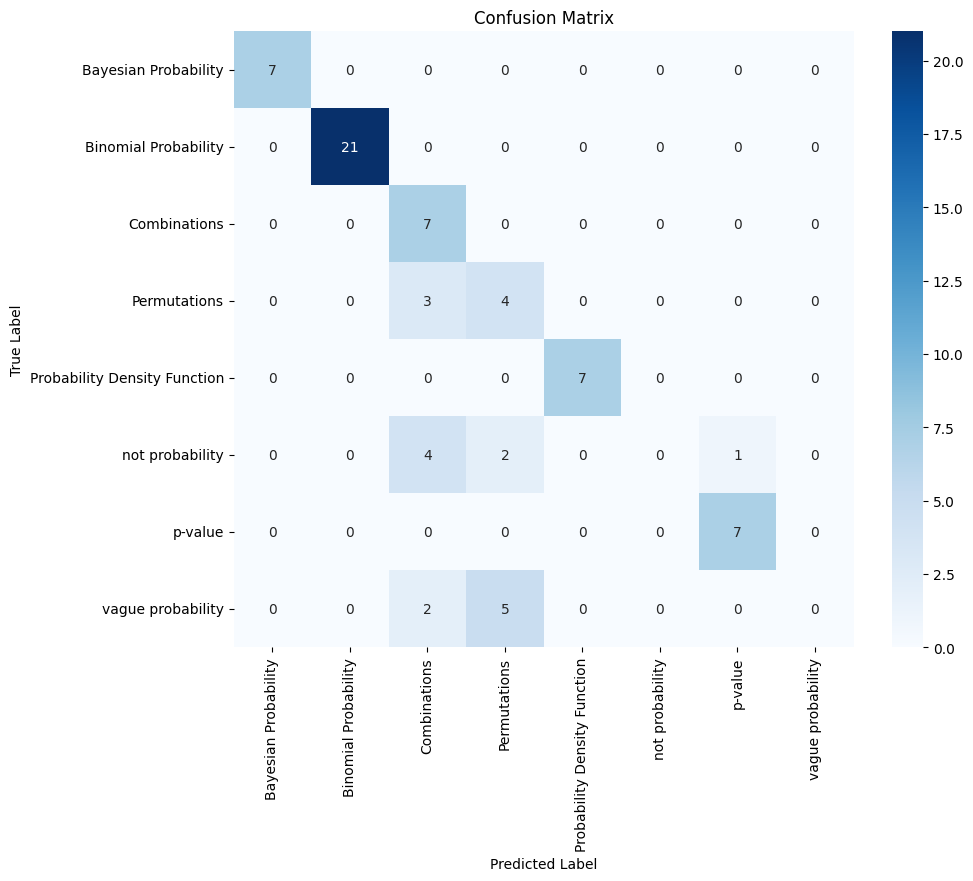

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
I think this is a binomial probability (binomial, bernoulli, or geometric) problem.
question was:" A basketball player has a seventy% free throw success rate. What is the probability of making exactly five out of eight free throws? "


In [59]:
# Evaluate model (confusion matrix using test dataset, then testing model w/ a question)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the index of the class with the highest probability

# Modify the true labels to merge 'binomial', 'bernoulli', and 'geometric' into 'binomial probability'
df_test["Problem Type"] = df_test["Problem Type"].replace(
    {"Bernoulli Process": "Binomial Probability", 
     "Geometric Probability": "Binomial Probability", 
     "Binomial Probability": "Binomial Probability"})

# Get true labels and apply the same encoding transformation for the merged classes
y_true = df_test["Problem Type"].apply(lambda x: label_encoder.transform([x])[0]).values

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Example usage
example_statement = "A basketball player has a 70% free throw success rate. What is the probability of making exactly 5 out of 8 free throws?"
example_statement = replace_numbers(example_statement)

# Call the classify_problem function to classify the example question
print(classify_problem(example_statement))
print("question was:\"", example_statement, "\"")


* It perfectly got all binomial probability related questions in the test set (21/21 binomial, bernoulli, and geometric), as well as p-value and PDF (14/14).
* Model has issues classifying non-probability and vague probability (0/14 of non-prob and vague prob). 
* Model correctly landed all 7/7 combination questions, but only landed 3/7 permutation questions. the other 4 were wrongly classified as permutations.

### Attempt 3b (consolidated permutations and combination classifications):


In [66]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import string

# Function to replace numbers with words
from num2words import num2words

def replace_numbers(text):
    return re.sub(r'\d+', lambda x: num2words(int(x.group())), text)

# Load dataset
df_train = pd.read_excel("LLM_question_dataset.xlsx", sheet_name="llm_training_dataset")
df_test = pd.read_excel("LLM_question_dataset.xlsx", sheet_name="llm_test_dataset")

# Preprocess text
def clean_text(text):
    text = replace_numbers(text)
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    return text

df_train["Processed Statement"] = df_train["Problem Statement"].apply(clean_text)
df_test["Processed Statement"] = df_test["Problem Statement"].apply(clean_text)

# Merge 'binomial', 'bernoulli', 'geometric' into 'binomial probability'
df_train["Problem Type"] = df_train["Problem Type"].replace(
    {"Bernoulli Process": "Binomial Probability", 
     "Geometric Probability": "Binomial Probability", 
     "Binomial Probability": "Binomial Probability",
     "Permutations": "Permutations and Combinations",
     "Combinations": "Permutations and Combinations"})

df_test["Problem Type"] = df_test["Problem Type"].replace(
    {"Bernoulli Process": "Binomial Probability", 
     "Geometric Probability": "Binomial Probability", 
     "Binomial Probability": "Binomial Probability",
     "Permutations": "Permutations and Combinations",
     "Combinations": "Permutations and Combinations"})

# Encode labels
label_encoder = LabelEncoder()
df_train["Encoded Type"] = label_encoder.fit_transform(df_train["Problem Type"])

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train["Processed Statement"])

X_train = pad_sequences(tokenizer.texts_to_sequences(df_train["Processed Statement"]), maxlen=50)
y_train = df_train["Encoded Type"].values

X_test = pad_sequences(
    tokenizer.texts_to_sequences(df_test["Processed Statement"]), maxlen=50)

# Build LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=50),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

# Function for prediction
def classify_problem(statement):
    processed = clean_text(statement)
    sequence = pad_sequences(tokenizer.texts_to_sequences([processed]), maxlen=50)
    pred = model.predict(sequence)
    class_index = np.argmax(pred)
    class_name = label_encoder.inverse_transform([class_index])[0]
    
    # Merge 'binomial probability' categories into a single label for prediction
    if class_name == "Binomial Probability":
        return "I think this is a binomial probability (binomial, bernoulli, or geometric) problem."
    elif class_name == "Permutations and Combinations":
        return "I think this is a permutations and combinations problem."
    else:
        return f"I think this is a {class_name} problem. [Click here](url)"


Epoch 1/10


/home/r/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4627 - loss: 1.9212 - val_accuracy: 0.0000e+00 - val_loss: 1.9974
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7098 - loss: 1.6181 - val_accuracy: 0.0000e+00 - val_loss: 2.6513
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7003 - loss: 1.1228 - val_accuracy: 0.0000e+00 - val_loss: 3.2211
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6315 - loss: 0.8917 - val_accuracy: 0.0000e+00 - val_loss: 3.7135
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7036 - loss: 0.7810 - val_accuracy: 0.0000e+00 - val_loss: 4.4467
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8527 - loss: 0.6150 - val_accuracy: 0.0000e+00 - val_loss: 4.7977
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8719 - loss: 0.5346 - val_accuracy: 0.0000e+00 - val_loss: 4.9783
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8804 - loss: 0.4094 - val_acc

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8577 - loss: 0.9156


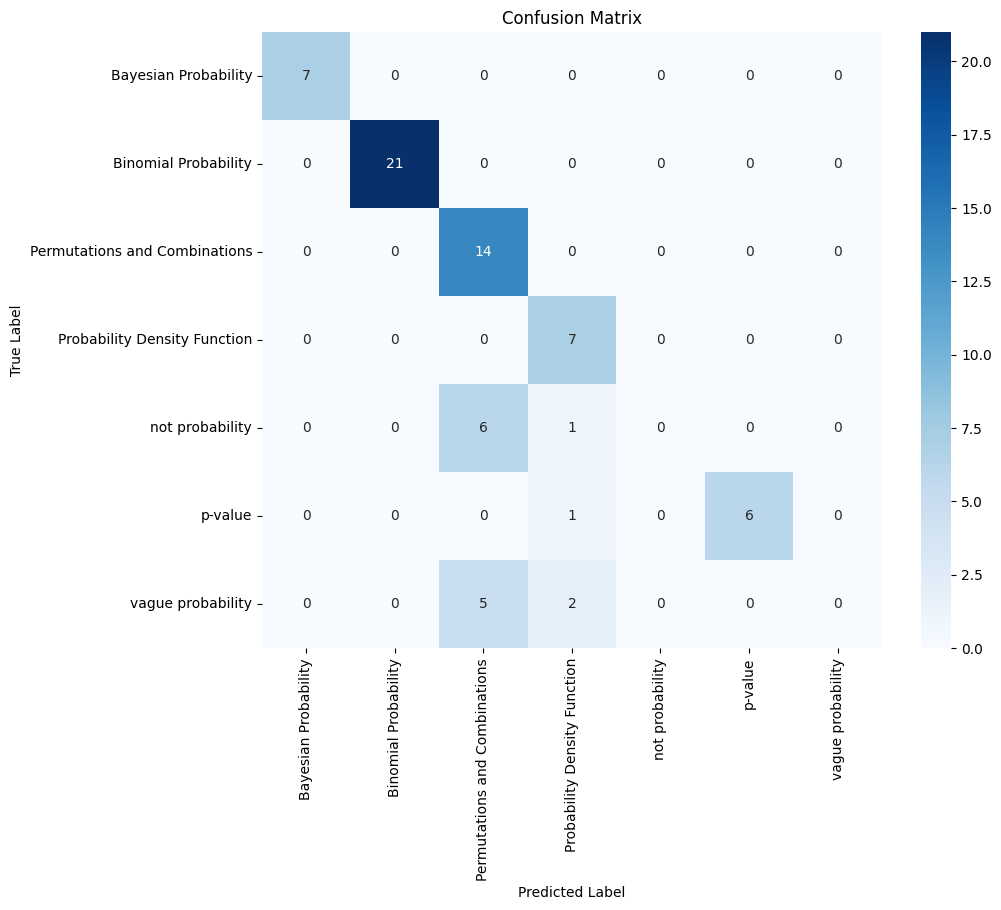

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
I think this is a binomial probability (binomial, bernoulli, or geometric) problem.
question was:" A basketball player has a seventy% free throw success rate. What is the probability of making exactly five out of eight free throws? "
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
I think this is a binomial probability (binomial, bernoulli, or geometric) problem.
question was:" A basketball player has a seventy% free throw success rate. What is the probability of making exactly five out of eight free throws? "


In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the index of the class with the highest probability

# Modify the true labels to merge 'binomial', 'bernoulli', and 'geometric' into 'binomial probability'
df_test["Problem Type"] = df_test["Problem Type"].replace(
    {"Bernoulli Process": "Binomial Probability", 
     "Geometric Probability": "Binomial Probability", 
     "Binomial Probability": "Binomial Probability",
     "Permutations": "Permutations and Combinations",
     "Combinations": "Permutations and Combinations"})

# Get true labels and apply the same encoding transformation for the merged classes
y_true = df_test["Problem Type"].apply(lambda x: label_encoder.transform([x])[0]).values

# Evaluate model on the test dataset (add verbose here to show evaluation details)
test_loss, test_accuracy = model.evaluate(X_test, y_true, verbose=1)  # Set verbose to 1 for more info during evaluation

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Example usage
example_statement = "A basketball player has a 70% free throw success rate. What is the probability of making exactly 5 out of 8 free throws?"
example_statement = replace_numbers(example_statement)

# Call the classify_problem function to classify the example question
print(classify_problem(example_statement))
print("question was:\"", example_statement, "\"")

# Example 2
example2 = "A basketball player has a 70% free throw success rate. What is the probability of making exactly 5 out of 8 free throws?"
example2 = replace_numbers(example2)

# Call the classify_problem function to classify the example question
print(classify_problem(example2))
print("question was:\"", example2, "\"")

